In [25]:
import tensorflow as tf
import os
import sys
import go_datafile_reader
import model
import numpy as np
import model_eval

In [2]:
train_dir = "../data/input/train"
test_dir = "../data/input/test"
ckpt_path = "../data/working/test.ckpt"

In [3]:
train_files = []
for subdir, dirs, files in os.walk(train_dir):
    for file in files:
        filepath = subdir + os.sep + file
        if filepath.endswith(".dat"):
            train_files.append(filepath)

test_files = []
for subdir, dirs, files in os.walk(test_dir):
    for file in files:
        filepath = subdir + os.sep + file
        if filepath.endswith(".dat"):
            test_files.append(filepath)

print "num train: %d, num test: %d" %(len(train_files), len(test_files))

num train: 498, num test: 54


In [4]:
#note you may have to change the os limit for number of open files to use the RandomAccessFileReader
#you can do this with the command "sudo ulimit -n 20000"
#if sudo can't find the ulimit command try the following below
#sudo sh -c "ulimit -n 20000 && exec su $LOGNAME"

reader = go_datafile_reader.RandomAccessFileReader(train_files, board_size=9)
test_reader = go_datafile_reader.GoDatafileReader(test_files, board_size=9)

test_reader.num_epochs = 0
test_features = []
test_targets = []
test_move_numbers = []
while(test_reader.num_epochs == 0):
    test_move_numbers.append(test_reader.move_index)
    final_state, _, feature_cube = test_reader.read_sample()
    test_features.append(feature_cube)
    test_targets.append(final_state)

Initializing pointers in 498 datafiles, this may take a few minutes


In [5]:
print len(reader.open_files)

498


In [6]:
x, ownership = model.place_holders(board_size=9)
y_conv = model.model(x, board_size=9)
loss = model.loss_function(ownership, y_conv)
train_op = model.train_step(loss)

prediction = tf.round(y_conv)
correct_prediction = tf.equal(ownership, prediction)
correct_count = tf.reduce_sum(tf.cast(correct_prediction, "float"))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())
saver = tf.train.Saver(tf.all_variables())

ckpt_dir, _ = os.path.split(ckpt_path)
ckpt = tf.train.latest_checkpoint(ckpt_dir)
if ckpt is not None:
    print("restore from previous checkpoint")
    saver.restore(sess, ckpt)

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Instructions for updating:
Please use tf.global_variables instead.
restore from previous checkpoint
INFO:tensorflow:Restoring parameters from ../data/working/test.ckpt


In [7]:
training_accuracies = []
test_accuracies = []
for k in range(2500):
    x_batch, y_batch = reader.get_batch(50)
    _, loss_value, y_value = sess.run([train_op, loss, y_conv], feed_dict={x:x_batch, ownership:y_batch})
    if k % 10 == 0:
        acc = accuracy.eval(feed_dict={x:x_batch, ownership:y_batch})
        training_accuracies.append(acc)
        print k, loss_value, acc
            
    if k % 1000 == 0:
        test_accuracy = model_eval.test_accuracy(test_features, test_targets, x, ownership, correct_count)
        test_accuracies.append(test_accuracy)
        print "Test accuracy: %f" %test_accuracy
    if k % 1000 == 0:
        print "Saving Checkpoint..."
        saver.save(sess, ckpt_path)
    

0 0.06580281 0.897037
Test accuracy: 0.199306
Saving Checkpoint...
10 0.070845485 0.8965432
20 0.06402102 0.9034568
30 0.07950077 0.8711111
40 0.06912346 0.8990123
50 0.062344413 0.905679
60 0.06912107 0.8982716
70 0.096773714 0.8567901
80 0.061576974 0.9108642
90 0.04927092 0.9291358
100 0.039824072 0.94790125
110 0.046400648 0.93777776
120 0.0650427 0.90518516
130 0.051293243 0.9276543
140 0.06190622 0.9125926
150 0.0649289 0.90839505
160 0.07841362 0.8896296
170 0.08591248 0.87259257
180 0.045988243 0.9380247
190 0.05329641 0.9219753
200 0.06047908 0.91209877
210 0.04352086 0.94
220 0.071672924 0.88987654
230 0.042158846 0.93901235
240 0.07529846 0.8881481
250 0.049269322 0.92444444
260 0.07392627 0.89555556
270 0.047569703 0.93580246
280 0.07626155 0.8824691
290 0.06791288 0.9059259
300 0.044255737 0.9385185
310 0.061131455 0.9195062
320 0.08820426 0.865679
330 0.0543798 0.92493826
340 0.042757772 0.9419753
350 0.06419619 0.91209877
360 0.043749083 0.9412346
370 0.04021929 0.943456

In [8]:
import matplotlib.pyplot as plt
import numpy as np

In [9]:
def rolling_mean(number_list, window = 20):
    means = np.zeros(len(number_list))
    for i in xrange(len(means)):
        sub_window = number_list[i-window+1:i+1]
        means[i] = np.mean(sub_window)
    return means

250


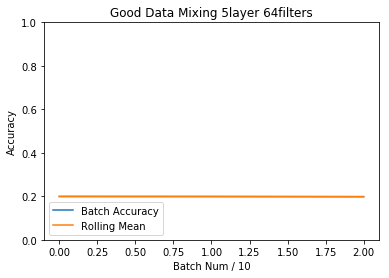

In [10]:
print len(training_accuracies)
means = rolling_mean(test_accuracies, 20)
plt.plot(test_accuracies, label="Batch Accuracy")
plt.plot(means, label= "Rolling Mean")
plt.title("Good Data Mixing 5layer 64filters")
plt.xlabel("Batch Num / 10")
plt.ylabel("Accuracy")
plt.ylim([0,1])
plt.legend(loc=3)
plt.show()

In [11]:
accuracies = []
y_trues = []
y_preds = []
feature_cubes = []
for i in xrange(len(test_features)):
    if i%500 == 0:
        print i
    x_, y_ = test_features[i], test_targets[i]
    y_val, y_pred, acc = sess.run([y_conv, prediction, accuracy], feed_dict={x:[x_], ownership:[y_]})
    accuracies.append(acc)
    y_trues.append(np.reshape(y_, [9,9]))
    y_preds.append(np.reshape(y_pred[0], [9,9]))
    feature_cubes.append(x_)

0
500
1000
1500
2000
2500
3000
3500
4000
4500


In [31]:
idx = 546
y_pred = y_preds[idx]
y_true = y_trues[idx]
feature_cube = feature_cubes[idx]

print(test_move_numbers[idx], accuracies[idx])
model_eval.print_info(feature_cube, y_pred, y_true, board_size=9)

(32, 0.9506173)


In [19]:
import pandas as pd

In [20]:
df = pd.DataFrame()
df["Move Num"] = test_move_numbers
df["Accuracy"] = accuracies
grouped = df.groupby("Move Num").aggregate(np.mean)


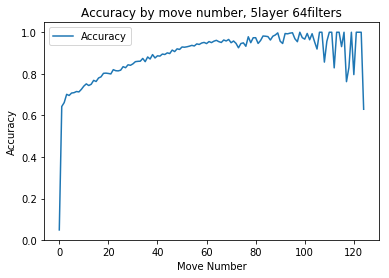

In [21]:
grouped.plot()
plt.title("Accuracy by move number, 5layer 64filters")
plt.xlabel("Move Number")
plt.ylabel("Accuracy")
plt.show()

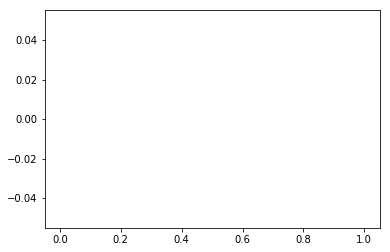

In [22]:
plot = plt.hist(df[df["Move Num"] == 250]["Accuracy"].values, bins = 40)
plt.show()